In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

In [4]:
np.random.seed(42)  # For reproducibility
T = 10000           # total time horizon

n_products = 3
n_intervals = 500

# Slightly Non Stationary Environment

### We will simulate a slightly non-stationary environment by partitioning the rounds into intervals. The distribution in each intervall will be costant and at each intervall the mean and standard deviation will be incremented by a quantity sampled from a distribution


In [ ]:
class NonStationaryEnvironment:

    def __init__(self, n_products, T, n_intervals, delta_mu = 0.05, delta_std = 0.01, mu_range=(0.3,0.7), std_range=(0.05,0.15), n_generator = None ):
        
        """Args:
           n_products: Number of products
           T: Number of timesteps
           n_intervals: Number of intervals for the non-stationary environment
           n_generator: Random number generator (optional, defaults to np.random.default_rng())"""
        
        self.n_products = n_products
        self.T = T
        self.n_intervals = n_intervals
        self.n_generator = n_generator if n_generator is not None else np.random.default_rng()
        self.mu_range = mu_range
        self.std_range = std_range
        self.delta_mu = delta_mu
        self.delta_std = delta_std

        self.interval_lenght = T // n_intervals


    def generate_valuations_parameters(self):
        "Generate mean and standard deviation for each product evaluation and for each timestep"

        #Initialize mean and std deviation matrix to all zeros
        means = np.empty((self.T, self.n_products))
        #stds = np.empty((self.T, self.n_products))

        stds = self.n_generator.uniform(low=self.std_range[0], high=self.std_range[1], size=self.n_products)

        #starting mean and standard deviation
        prev_means = self.n_generator.uniform(low=self.mu_range[0], high=self.mu_range[1], size=self.n_products)
        #prev_stds = self.n_generator.uniform(low=self.std_range[0], high=self.std_range[1], size=self.n_products)

        for i in range(self.n_intervals):
            start = i * self.interval_lenght
            end = (i+1) * self.interval_lenght if i < self.n_intervals-1 else self.T
        
            # nuovo valore = valore precedente + piccolo disturbo
            delta_mean = self.n_generator.uniform(-self.delta_mu, self.delta_mu, size=self.n_products)  
            #delta_std  = self.n_generator.uniform(-self.delta_std, self.delta_std, size=self.n_products)
        
            new_means = np.clip(prev_means + delta_mean, 0, 1)
            #new_stds  = np.clip(prev_stds + delta_std, self.std_range[0], self.std_range[1])
        
            means[start:end, :] = new_means
            #stds[start:end, :]  = new_stds
        
            #prev_means, prev_stds = new_means, new_stds
            prev_means = new_means

        self.means = means
        self.stds = stds


    def get_valuations(self, t):
        
        """Get the valuations for all products at time t"""
        valuations = self.n_generator.normal(loc=self.means[t], scale=self.stds)
        return valuations
    
    #Get the rewards for all products at time t given the prices
    #If the valuation of the buyer is higher than the price the reward is the price, otherwise is 0
    def get_rewards(self, t, prices):
        
        #Get the valuations for each product at time t
        valuations = self.get_valuations(t)

        #If valuation is higher then price, then buy (true)
        if_buy = (valuations >= prices).astype(bool)
        
        return prices*if_buy

### Evolution of the mean and standard deviation during time

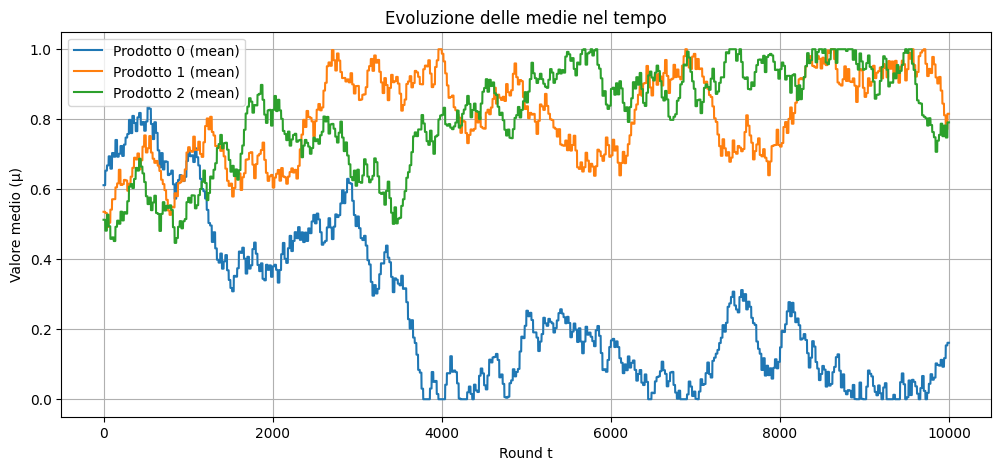

In [19]:
env = NonStationaryEnvironment(n_products=n_products, T=T, n_intervals=n_intervals)
env.generate_valuations_parameters()

# Plot delle medie
plt.figure(figsize=(12,5))

for p in range(n_products):
    plt.plot(env.means[:, p], label=f"Prodotto {p} (mean)")

plt.title("Evoluzione delle medie nel tempo")
plt.xlabel("Round t")
plt.ylabel("Valore medio (μ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot delle deviazioni standard
#plt.figure(figsize=(12,5))

#for p in range(n_products):
#    plt.plot(env.stds[p], label=f"Prodotto {p} (std)")

#plt.title("Evoluzione delle deviazioni standard nel tempo")
#plt.xlabel("Round t")
#plt.ylabel("Deviazione standard (σ)")
#plt.legend()
#plt.grid(True)
#plt.show()


# Combinatorial-UCB Agent with Sliding Window

In [ ]:
class UCBSWAgent:

    def __init__(self, n_products, price_options, inventory, T, W,
                 confidence_bound=1.0, rho_penalty=1.0, use_pen_rho=True, selection_method='sampling', rng = None):

        self.rng = rng if rng else np.random.default_rng()

        #Number of rounds
        self.T = T

        #Window size
        self.W = W

        #Current round
        self.t = 0
        #Number of products
        self.n = n_products
        #Number of possible prices
        self.n_price = len(price_options)

        #Total initial inventory
        self.B = inventory

        self.remaining_inventory = inventory

        #Map product -> last price chosen for the product
        self.current_action= {}

        #Sliding window for the rewards of each price for each product and price
        self.cache_f = np.full((n_products, W, self.n_price), np.nan)    #3D Matrix [product, t in the window, price]

        #Sliding window for the purcase probabilities for each product and price
        self.cache_c = np.full((n_products, W, self.n_price), np.nan)    #3D Matrix [product, t in the window, price]

         # equality constraints: sum of arm probabilities = 1 for each product
        self.A_eq = np.zeros((self.n, self.n*self.n_price))
        for dim in range(self.n):
            self.A_eq[dim,dim*self.n_price:(dim+1)*self.n_price] = 1
        self.b_eq = np.ones(self.n)
    

    #For each product select a price. Return the list of prices for each product
    def select_action(self):


        product_subset = []
        price_subset = []

        #No inventory left, return an empty action
        if self.remaining_inventory < self.n:
            self.current_action_indices_map = {}
            return product_subset, price_subset
        
        #First n_price round, pull each product with the t price
        if self.t < self.n_price:
            products_subset = list(range(self.n))
            price_subset = np.full(self.n, self.t, dtype=int)
            return products_subset, price_subset
        
        #large_value = 1e7
        small_value = 1e-7

        #Number of times price p for product x was picked in the last W rounds
        n_pulls_last_w = np.sum(~np.isnan(self.cache_f), axis=1)

        #Exploration term of the CB, we add a small value to avoid division by zero
        sigma = np.sqrt(2*np.log(self.W)/(n_pulls_last_w+small_value))
        f_ucbs = np.nanmean(self.cache_f, axis=1) + sigma
        c_lcbs = np.nanmean(self.cache_c, axis=1) - sigma

        gamma = self.compute_opt(f_ucbs, c_lcbs)

        #Sample prices for each product based on the computed distribution gamma
        for product in range(self.n):
            #Index of the price
            self.current_action[product] = self.rng.choice(self.n_price, p=gamma[product])
            #product_subset.append(product)
            price_subset.append(self.current_action[product])

        #return product_subset, price_subset
        return price_subset

    def update(self, f_t, c_t):
        for product in range(self.n):
            # Rimuovi la riga più vecchia (asse=1 = dimensione W)
            self.cache_f[product] = np.delete(self.cache_f[product], 0, axis=0)
            self.cache_c[product] = np.delete(self.cache_c[product], 0, axis=0)

            # Crea nuova riga (NaN per tutti i prezzi)
            new_f_row = np.repeat(np.nan, self.K)
            new_c_row = np.repeat(np.nan, self.K)

            # Aggiorna con reward e costo osservato per il prezzo scelto
            new_f_row[self.a_t[product]] = f_t[product]
            new_c_row[self.a_t[product]] = c_t[product]

            # Aggiungi la nuova riga in fondo
            self.cache_f[product] = np.vstack((self.cache_f[product], new_f_row))
            self.cache_c[product] = np.vstack((self.cache_c[product], new_c_row))

            # Aggiorna budget
            self.remaining_inventory -= c_t[product]

        # Ricalcola rho e avanza il tempo
        self.rho = self.B / (self.T - self.t)
        self.t += 1

    def compute_opt(self, f_ucbs, c_lcbs):
    

        # Flatten W and C for LP
        c = -f_ucbs.flatten()

        # Compute current required selling rate for the shared inventory
        remaining_rounds = max(1, self.T - self.t)
        current_rho_total = max(self.remaining_inventory / remaining_rounds, 0)

        # Inequality constraints (shared inventory)
        A_ub = [c_lcbs.flatten()]
        b_ub = [current_rho_total]

        #Coefficients for equality constraints
        A_eq = self.A_eq

        # Bounds for each variable (gamma_ki between 0 and 1)
        bounds = [(0, 1) for _ in range(self.n*self.n_price)]

        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=self.b_eq,
                                 bounds=bounds, method='highs')

            if res.success:
                gamma_flat = res.x
                # Reshape gamma back to (n_products, n_price_options)
                gamma = gamma_flat.reshape((self.n, self.n_price))

                # Ensure valid probability distribution for each product
                for product_idx in range(self.n):
                    gamma[product_idx, :] = np.maximum(gamma[product_idx, :], 0)
                    sum_gamma = np.sum(gamma[product_idx, :])
                    if sum_gamma > 0:
                         gamma[product_idx, :] /= sum_gamma
                    else:
                         # Fallback: uniform distribution for this product
                         gamma[product_idx, :] = np.ones(self.n_price) / self.n_price

                return gamma
            else:
                # Fallback: uniform distribution for all products
                return np.ones((self.n, self.n_price)) / self.n_price
        except Exception as e:
            print(f"LP Error: {e}")
            # Fallback: uniform distribution for all products
            return np.ones((self.n, self.n_price)) / self.n_price



